In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar -xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
!python3 -m pip install geopandas > /dev/null

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
df = spark.createDataFrame([{"hello": "world"} for x in range(1000)])
df.show(3)

+-----+
|hello|
+-----+
|world|
|world|
|world|
+-----+
only showing top 3 rows



In [ ]:
import urllib.request
import zipfile
urllib.request.urlretrieve("http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs","apache_logs")
urllib.request.urlretrieve('https://download.ip2location.com/lite/IP2LOCATION-LITE-DB1.CSV.ZIP', 'IP2LOCATION-LITE-DB1.CSV.zip')
with zipfile.ZipFile('IP2LOCATION-LITE-DB1.CSV.zip') as zipf:
    zipf.extractall('.')

# Task 1
Narysować wykres (pie chart) popularności sprzeglądarek

Format of the logs is given here: https://github.com/elastic/examples/blob/master/Common%20Data%20Formats/apache_logs/logstash/apache_logstash.conf

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
sc = spark.sparkContext

In [ ]:
lines = sc.textFile("apache_logs")

In [ ]:
useragent_to_browser = {
    "Firefox": "Firefox",
    "OPR": "Opera",
    "Edg": "Edge",
    "Chrome": "Chrome",
    "Safari": "Safari",
    }

def parse_browser(s):
    for useragent in useragent_to_browser.keys():
        if useragent in s:
            return useragent_to_browser[useragent]
    return "Other"

In [ ]:
browserLines = lines.map(lambda s: parse_browser(s))

In [ ]:
counts = browserLines.countByValue()
counts

defaultdict(int,
            {'Chrome': 3152,
             'Firefox': 2778,
             'Safari': 764,
             'Other': 3285,
             'Opera': 21})

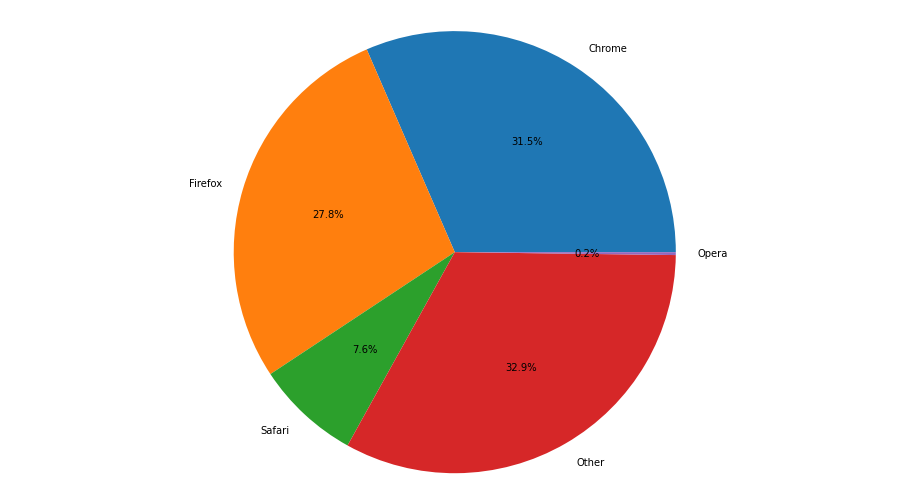

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))

ax.pie(counts.values(), labels=counts.keys(), autopct='%1.1f%%')

ax.axis('equal')
plt.show()

# Task 2
Narysować wykres słupkowy liczby wywołań (request) na godzinę w zależności od czasu, pogrupowane po kodzie odpowiedzi (200, 404, etc)

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
lines = sc.textFile("apache_logs")

In [ ]:
lineSplits = lines.map(lambda s: s.split(' '))
lineSplits = lineSplits.map(lambda s: (s[3][1:-1].split(':')[0], s[3][1:-1].split(':')[1], s[8]))

In [ ]:
df = spark.createDataFrame(lineSplits, schema=['day', 'hour', 'status'])

In [ ]:
df.select('day').distinct().collect()

[Row(day='19/May/2015'),
 Row(day='20/May/2015'),
 Row(day='18/May/2015'),
 Row(day='17/May/2015')]

In [ ]:
counts_df = df.groupBy('day', 'hour', 'status').count()
counts_df = counts_df.sort('day', 'hour', 'status')
counts_df.show()

+-----------+----+------+-----+
|        day|hour|status|count|
+-----------+----+------+-----+
|17/May/2015|  10|   200|   73|
|17/May/2015|  10|   404|    1|
|17/May/2015|  11|   200|  107|
|17/May/2015|  11|   301|    1|
|17/May/2015|  11|   304|    2|
|17/May/2015|  11|   404|    1|
|17/May/2015|  12|   200|  109|
|17/May/2015|  12|   301|    2|
|17/May/2015|  12|   304|    4|
|17/May/2015|  13|   200|   94|
|17/May/2015|  13|   301|   18|
|17/May/2015|  13|   304|    1|
|17/May/2015|  13|   404|    5|
|17/May/2015|  14|   200|   88|
|17/May/2015|  14|   206|    1|
|17/May/2015|  14|   301|   31|
|17/May/2015|  15|   200|  106|
|17/May/2015|  15|   206|   16|
|17/May/2015|  15|   304|    2|
|17/May/2015|  15|   404|    1|
+-----------+----+------+-----+
only showing top 20 rows



In [ ]:
statuses = [row['status'] for row in counts_df.select('status').distinct().collect()]
statuses

['200', '206', '404', '403', '416', '500', '304', '301']

In [ ]:
counts_df_pd = counts_df.toPandas()
days = counts_df.select('day').distinct().toPandas()['day'].tolist()
counts_dfs = {day: counts_df_pd[counts_df_pd['day'] == day] for day in days}

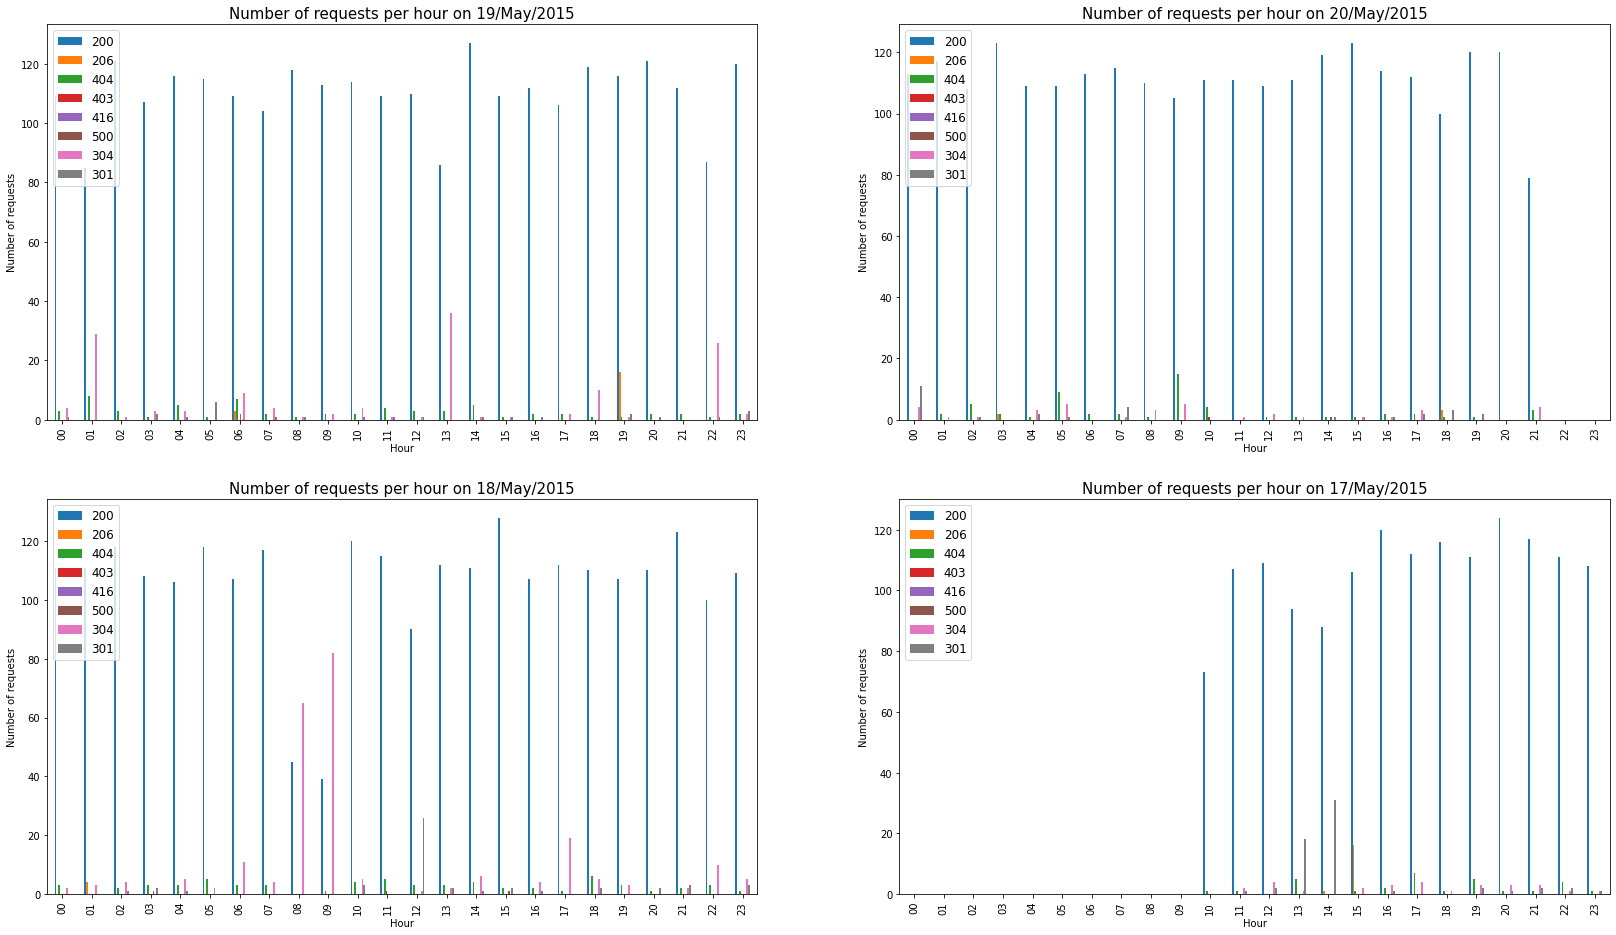

In [ ]:
hours = [str(i).zfill(2) for i in range(24)]

def get_counts_from_df(df, hour: str, status: str):
    values = df[(df['hour'] == hour) & (df['status'] == status)]['count'].values
    if len(values) != 0:
        return values[0]
    else:
        return 0

fig, axes = plt.subplots(2, 2, figsize=(28,16))

idx_map = lambda i: (i // 2, i % 2)

for i, day in enumerate(days):
    hours_status_counts = {}
    for status in statuses:
        counts_per_hour = [get_counts_from_df(counts_dfs[day], hour, status) for hour in hours]
        hours_status_counts[status] = np.array(counts_per_hour)

    status_per_hour_df = pd.DataFrame(hours_status_counts, index=hours)
    status_per_hour_df.plot.bar(ax=axes[idx_map(i)])
    axes[idx_map(i)].set_title(f'Number of requests per hour on {day}', fontsize=15)
    axes[idx_map(i)].legend(loc=2, prop={'size': 12})
    axes[idx_map(i)].set_xlabel('Hour')
    axes[idx_map(i)].set_ylabel('Number of requests')
plt.show()

# Task 3
Narysować wykres rankingu pobieranych zasobów według typów plików (html, css, png, etc.)

In [ ]:
import os
import pandas as pd

In [ ]:
lines = sc.textFile("apache_logs")

In [ ]:
paths = lines.map(lambda s: s.split(' ')[6])

In [ ]:
url_special_characters = ['"', '%22', '<', '%3C', '>', '%3E', '#', '%23', '%',
    '%25', ' ', '%20', '$', '%24', '&', '%26', '+', '%2B', ',', '%2C', '/',
    '%2F', ':', '%3A', ';', '%3B', '=', '%3D', '?', '%3F', '@', '%40',
]

def remove_suffix(string, after):
    return string.split(after)[0]

def get_extension(path):
    _, extension = os.path.splitext(path)
    for ch in url_special_characters:
        if ch in extension:
            extension = remove_suffix(extension, ch)
    if extension == '.' or extension == '':
        return 'None'
    return extension

In [ ]:
extensions = paths.map(lambda s: get_extension(s))
counts = extensions.countByValue()

In [ ]:
df = pd.DataFrame({'format': counts.keys(), 'count': counts.values()})
df = df.astype({'count': int})
df = df.sort_values(by=['count'], ascending=True)

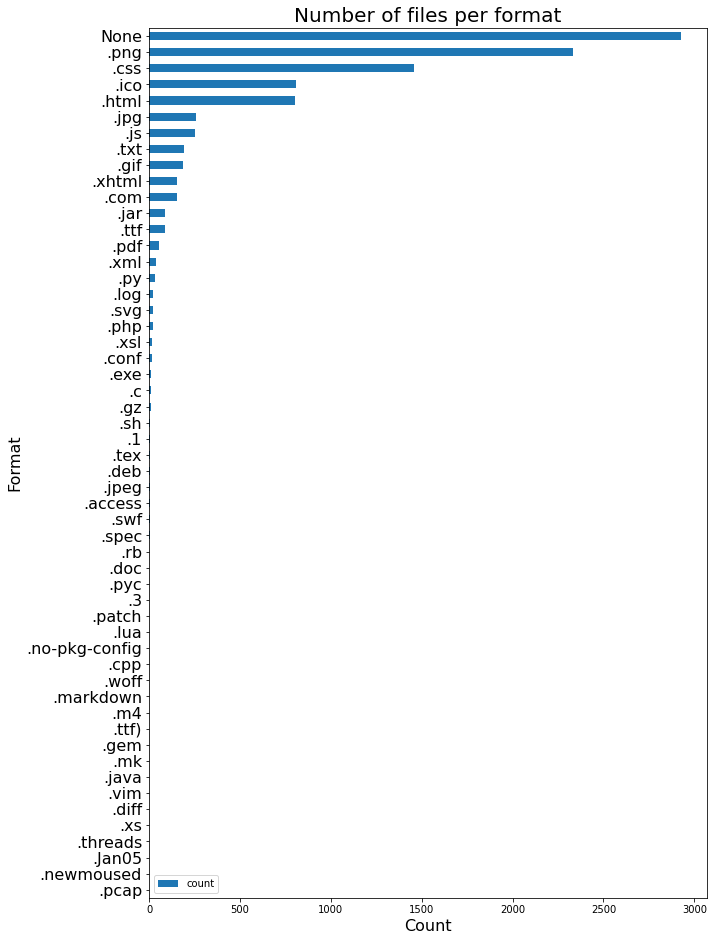

In [ ]:
df.plot.barh(x='format', y='count', figsize=(10, 16))
plt.title('Number of files per format', fontsize=20)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Format', fontsize=16)
plt.yticks(fontsize=16)


plt.show()

# Task 4
Narysować mapę z lokalizacjami klientów

In [ ]:
import geopandas as gpd
import json
import ipaddress

IP_TO_LOC_DF = pd.read_csv('IP2LOCATION-LITE-DB1.CSV')

def get_country(ip: str):
    ip_int = int(ipaddress.ip_address(ip))
    df_index = (IP_TO_LOC_DF['0'] <= ip_int) & (IP_TO_LOC_DF['16777215'] >= ip_int)
    row = IP_TO_LOC_DF[df_index]
    country = row['-.1'].values[0]
    if country == '-':
        return None
    return country

In [ ]:
lines = sc.textFile("apache_logs")
ips = lines.map(lambda s: s.split(' ')[0])
localizations = ips.map(lambda s: get_country(s))

In [ ]:
# map country names from iplocation database format to geopandas
format_map = {
    'Russian Federation': 'Russia',
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'Singapore': None,
    'Korea (Republic of)': 'South Korea',
    'Hong Kong': None,
    'Moldova (Republic of)': 'Moldova',
    'Venezuela (Bolivarian Republic of)': 'Venezuela',
    'Iran (Islamic Republic of)': 'Iran',
    'Taiwan (Province of China)': 'Taiwan',
    'Viet Nam': 'Vietnam',
    'Syrian Arab Republic': 'Syria',
    'Tanzania, United Republic of': 'Tanzania',
    'Cook Islands': None,
    'Bosnia and Herzegovina': 'Bosnia and Herz.',
    'Malta': None,
    'North Macedonia': 'Macedonia',
}

In [ ]:
localizations =localizations.map(lambda s: format_map[s] if s in format_map else s)
counts = localizations.countByValue()

In [ ]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
count_per_country = [counts[country] for country in countries['name'].tolist()]

countries['requests'] = count_per_country

In [ ]:
countries

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,requests
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",1
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",0
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",216
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",4030
...,...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",26
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",6
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",0
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",1


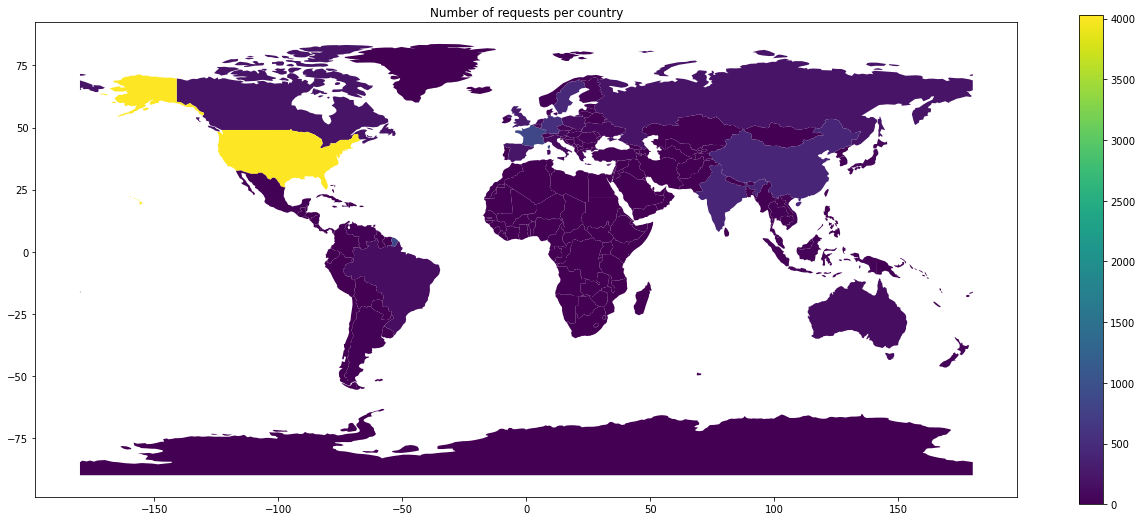

In [ ]:
fig, ax = plt.subplots(figsize=(22, 9))
ax.set_title('Number of requests per country')
countries.plot(column='requests', ax=ax, legend=True)
plt.show()

# Task 5

In [ ]:
# Some of bots have bot as useragent. Assumption: all bots do that.
# 66.249.73.135 - - [20/May/2015:04:05:24 +0000] "GET /?flav=atom HTTP/1.1" 200 32352 "-" "Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)"

In [ ]:
lines = sc.textFile("apache_logs")

In [ ]:
onesAndZeroes = lines.map(lambda s: 1 if 'bot' in s else 0)
onesAndZeroes.sum()

1312

From Task 1 we've obtained that there are 3285 browsers of unknown type. Presumably these are bots of some kind.